# Imbalanced Fraud Detection Project

In this project, the objective is to spot suspected Fraud transaction on Credit Cards.

As shown in the flowchart below, you can see the summarise process taken to achieve the objective. However, further explanation can be seen in different parts of this notebook:

# 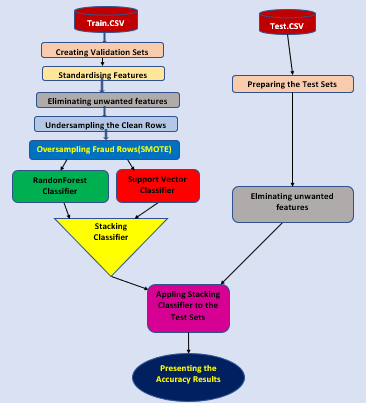

## Importing the required libraries: 

For visualiation both matplotlib and seaborn has been imported to ensure different types of plot can be implemented.

Variety of Sklearn libraries have been imported for chosen Classifier algorithms, standardising and accuracy measures.

In [169]:
import time                      # Import libraries
start_time = time.time()

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import imblearn
from imblearn.over_sampling import SMOTE
import collections
from tqdm import tqdm_notebook as tqdm

from sklearn.preprocessing import StandardScaler      # Import sklearn libraries
from sklearn.utils import shuffle
from sklearn import datasets, model_selection
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier


## Importing the CSV files for training and validation sets:

As the original train.CSV file is quite large(above 100MB), I have splitted the CSV file to 2 CSV files(train1.csv and train2.csv).
However, after importing the 2 csv files I did merge them to have everything in one single dataframe.

In [104]:
df = pd.read_csv('./DATA/creditcard_train1.csv')     # Import train csv files to dataframes
df2 = pd.read_csv('./DATA/creditcard_train2.csv')
df = pd.concat([df,df2[1:]])                        # Merge the 2 dataframes
del df2                                       # Delete one of the dataframes
df = shuffle(df)                              # Shuffle the dataframe            

So far so good, no NANs in our imported data:

In [105]:
df.isnull().sum().sum()   # Check if there is any Nan in the dataframe

0

Let create a features list, as it will be useful at some point later when we need to modify the number of features:

In [106]:
features_list = df.columns.values.tolist()  # Create a list for the name of all the features
for list_idx in features_list:
    print(list_idx, end=' ')               # Printing the list of features and label
features_list.pop()                        # Deleting the list entity of the list as it is the label(not feature)
print("\n")
for list_idx in features_list:
    print(list_idx, end=' ')               # Printing the list of only features

Time V1 V2 V3 V4 V5 V6 V7 V8 V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 Amount Class 

Time V1 V2 V3 V4 V5 V6 V7 V8 V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 Amount 



Let make sure there is only Two differnt values in our label column("Class"), for fraud and clean(or non fraud) transactions:

In [107]:
df.Class.unique()  # Ensuring the Class column is binary as expected

array([0, 1], dtype=int64)



Now the we know, we have Two different values for the label, let convert the type for this column to Boolean:

In [108]:
df.Class=df.Class.astype("bool")  # Converting the Class label to boolean type from int64
collections.Counter(df.Class)       # Checking how inbalance is our data

Counter({False: 198998, True: 364})

Let see if there is any dupicate rows in the dataframe(df) and leave only one of them as there is absoultely no point to have duplicate rows:

In [109]:
df.duplicated().sum()    # Check for duplication

585

In [110]:
df.drop_duplicates(inplace = True)  # Keeping only one of the duplication rows if there is any
collections.Counter(df.Class)        # Check again how our inbalance data looks like

Counter({False: 198422, True: 355})

### WOW!
See how imbalance is the Data! Less than quarter of a percent of the rows are representing the fraud transactions, we certainly need to do something about it: 

In [111]:
px.histogram(df, "Class", labels={"Class": "Fraudness"}, title="Count of Credit Card Transactions",color="Class" ,color_discrete_map = {True:'red',False:'blue'})

In [112]:
fraud_count = df.Class[df["Class"]==True].count() # Counting the number of fraud and clean transactions
clean_count = len(df) - fraud_count
print('Number of fraud Transactions is ', fraud_count ,' which is ', round(100*fraud_count/len(df),3) , "% of the dataset.\n")
print('Number of clean Transactions is ', clean_count ,' which is ', round(100*clean_count/len(df),3) , "% of the dataset.")

Number of fraud Transactions is  355  which is  0.179 % of the dataset.

Number of clean Transactions is  198422  which is  99.821 % of the dataset.


## Splitting the data to training and validation sets:
Now it is certinly the correct time to do this split prior to standardisation in order to avoid any **data leakage** which can have an overfit consequence in our model.

In [113]:
df_label=df["Class"]                    # Creating a label only dataframe
df_features = df.drop("Class", axis=1)   # Creating a feature only dataframe

In [114]:
# Separating the train and validation sets for both labels and feautures
X_train, X_val, Y_train, Y_val = train_test_split(df_features, df_label, test_size=0.33, random_state=42)

## Standardising features(if required):
Based on the mean and std of features(V1...V28) we do not need to apply standardising methods to them. 
However, obviously the "Time" and "Amount" features require standardising:

In [115]:
df.describe() # check the description of all the numeric features(which are all the features) 

Time             V1             V2             V3  \
count  198777.000000  198777.000000  198777.000000  198777.000000   
mean    94804.312295       0.009128      -0.002808      -0.001230   
std     47505.945585       1.945998       1.634265       1.513868   
min         0.000000     -56.407510     -72.715728     -48.325589   
25%     54213.000000      -0.914367      -0.600632      -0.891180   
50%     84650.000000       0.025907       0.063052       0.177015   
75%    139333.000000       1.317510       0.798376       1.024675   
max    172792.000000       2.454930      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  198777.000000  198777.000000  198777.000000  198777.000000   
mean       -0.002365      -0.002014       0.002832       0.001295   
std         1.415270       1.386037       1.335744       1.243473   
min        -5.683171    -113.743307     -26.160506     -43.557242   
25%        -0.848943      -0.691728      -0.768274      -0.554928   
50%        -0.022399      -0.054543      -0.273589       0.038361   
75%         0.739895       0.611792       0.398343       0.567914   
max        16.875344      34.801666      73.301626     120.589494   

                  V8             V9  ...            V20            V21  \
count  198777.000000  198777.000000  ...  198777.000000  198777.000000   
mean       -0.001479       0.001572  ...      -0.000200      -0.000324   
std         1.177720       1.099267  ...       0.769537       0.725705   
min       -50.688419     -13.434066  ...     -54.497720     -22.889347   
25%        -0.208845      -0.642858  ...      -0.211763      -0.228663   
50%         0.021971      -0.049979  ...      -0.062789      -0.030281   
75%         0.325913       0.599765  ...       0.131815       0.185224   
max        20.007208      15.594995  ...      38.117209      27.202839   

                 V22            V23            V24            V25  \
count  198777.000000  198777.000000  198777.000000  198777.000000   
mean       -0.001453      -0.000254       0.000687      -0.000352   
std         0.724582       0.631072       0.605287       0.521072   
min        -9.499423     -44.807735      -2.824849     -10.295397   
25%        -0.542464      -0.161780      -0.354038      -0.317835   
50%         0.006057      -0.010666       0.041286       0.015550   
75%         0.526075       0.148339       0.440253       0.350490   
max         8.361985      22.083545       4.584549       7.519589   

                 V26            V27            V28         Amount  
count  198777.000000  198777.000000  198777.000000  198777.000000  
mean        0.000263       0.001165       0.000728      88.854125  
std         0.482129       0.399762       0.328130     253.999620  
min        -2.604551     -22.565679     -15.430084       0.000000  
25%        -0.326248      -0.070785      -0.052444       5.510000  
50%        -0.052173       0.001340       0.011317      22.000000  
75%         0.240273       0.090650       0.078043      77.070000  
max         3.517346      31.612198      33.847808   25691.160000  

[8 rows x 30 columns]

In [116]:
scalar = StandardScaler()   # Standardising Time and Amount in traning dataframe
X_train[['Time', 'Amount']] = scalar.fit_transform(X_train[['Time', 'Amount']])

scalar = StandardScaler()   #  Standardising Time and Amount in validation dataframe
X_val[['Time', 'Amount']] = scalar.fit_transform(X_val[['Time', 'Amount']])

C:\Users\AICORE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\aicore\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\AICORE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

## Undersampling the rows with Non fraud transactions:
Let create few dataframes related to the training data to be able to do further analysis and visualisation:

In [117]:
df_train = pd.DataFrame(X_train, copy = True)  # Creating a training dataframe with all the features and label
df_train["Class"]=Y_train

Now we can choose what fraction of the training data with non fraud transactions need to stay for further analysis:

In [118]:
df_fraud = df_train[df_train.Class==True]                    # Creating a fraud only dataframe
df_clean = df_train[df_train.Class==False].sample(frac=.15)   # Creating a clean only dataframe with the desired size

In [119]:
df_train = pd.concat([df_fraud, df_clean])    # Merging the fraud and the clean(reduced size) dataframes
collections.Counter(df_train.Class)           

Counter({True: 192, False: 27284})

Now, we can see despite the reduction to the number of non fraud rows, we still have far more non fraud rows than fraud.
But, we want to keep the non fraud rows number as they are, and then oversample the fraud rows in the next section:

In [120]:
px.histogram(df_train, "Class", labels={"Class": "Fraudness"}, title="Count of Credit Card Transactions",color="Class" ,color_discrete_map = {True:'red',False:'blue'})

## Oversampling the Fraud rows:

Here you go. This is why, I did not undersample the non fraud rows down to the number of fraud row.
Applying **SMOTE** to our training datasets we are about to a balanced dataset:

In [121]:
df_label=df_train["Class"]   # Splitting the training dataframe to label and features to prepare for SMOTE
df_features = df_train.drop("Class", axis=1)                      

In [122]:
sm = SMOTE(random_state=42)  # Oversampling the training dataset to have same number of fraud and clean transactions
X_train, Y_train = sm.fit_sample(df_features, df_label)  

In [123]:
df_balanced = pd.DataFrame(X_train, copy = True) # Creating a new balanced dataframe
df_balanced["Class"]=Y_train
df_balanced = shuffle(df_balanced)

In [124]:
px.histogram(df_balanced, "Class", labels={"Class": "Fraudness"}, title="Count of Credit Card Transactions",color="Class" ,color_discrete_map = {True:'red',False:'blue'})

### Eliminating unwanted features which has low absoulte value for correlation with the label("Class"):

I have considered absolute value of correlation lower than 0.5, between any feature with the label as almost irrelevant and these features can be eliminated. 

Text(5, 0, 'Correlation Heatmap of Fraud dataframe')

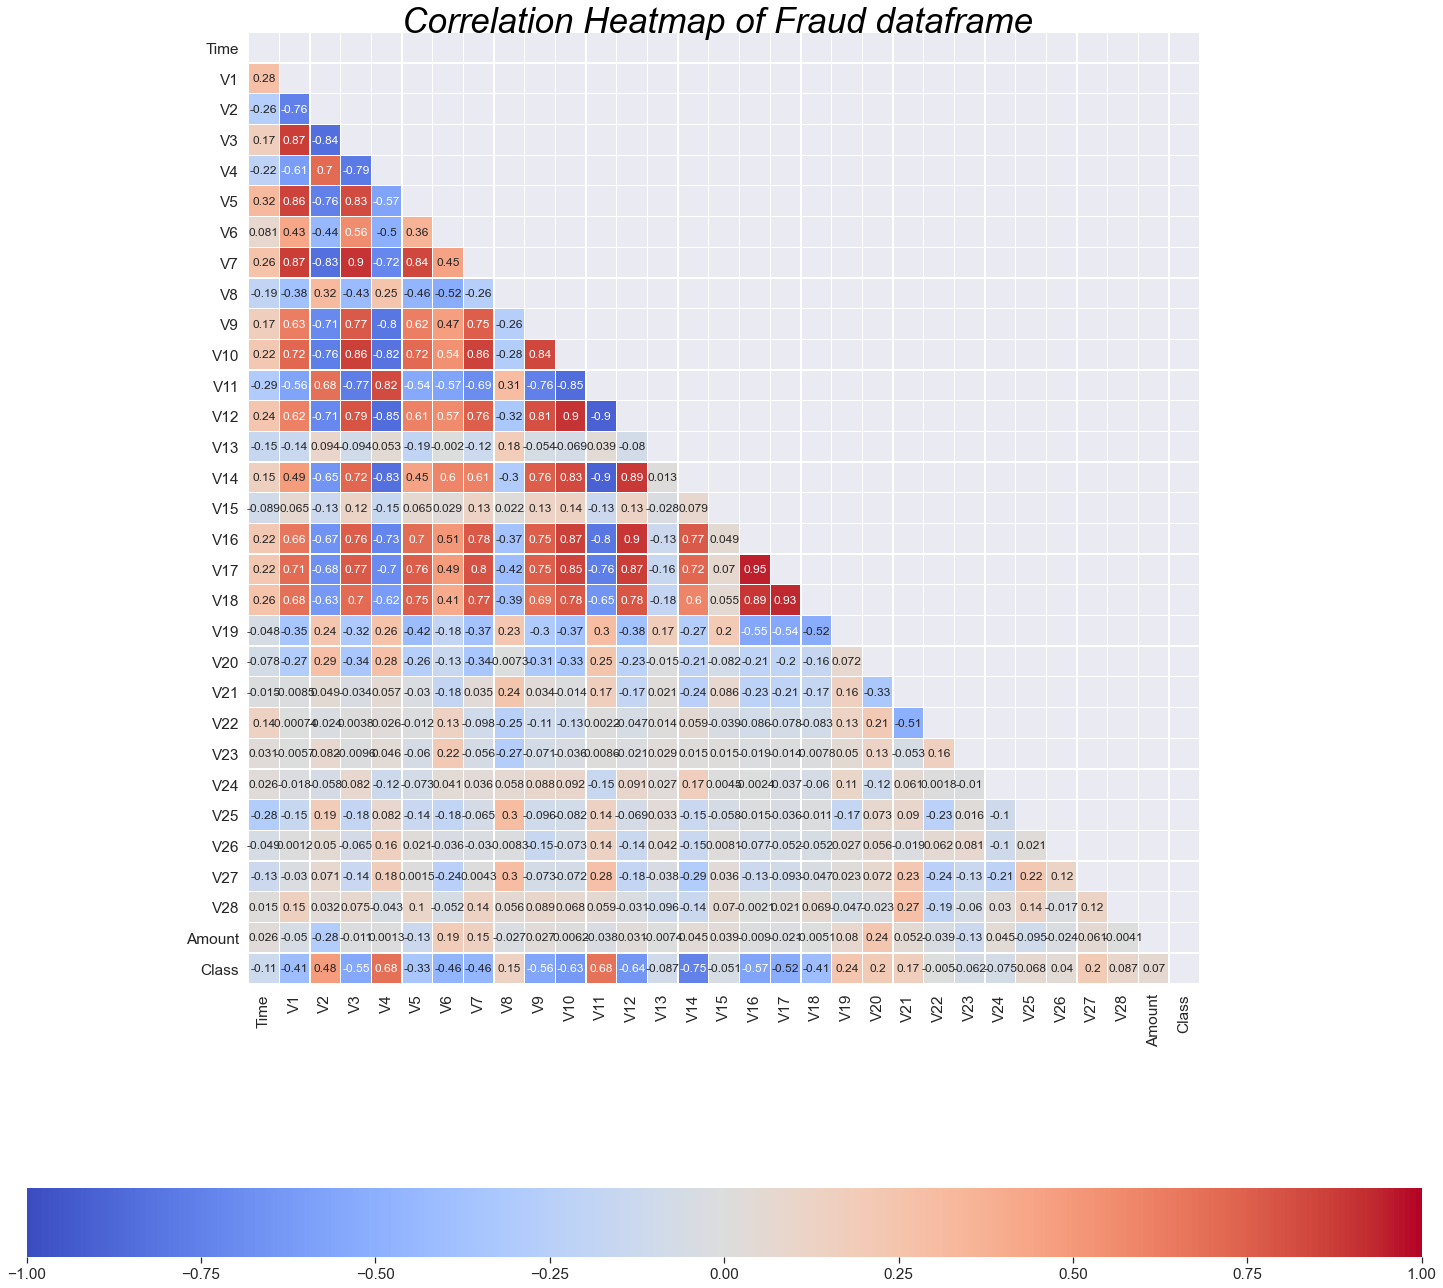

In [125]:
sns.set_theme(style="white")
sns.set(font_scale=1.4)
# Compute the correlation matrix
corr = df_balanced.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Setup the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1,vmin=-1, center=0, annot=True, annot_kws={"size": 12}, fmt='.2g',square=True, linewidths=.3,cbar_kws= {'orientation': 'horizontal'})
plt.text(5,0, "Correlation Heatmap of Fraud dataframe", fontsize = 35, color='Black', fontstyle='italic')

OK! Now looking at the bottom row of the Heatmap we can get rid of several features by dropping them from the dataframe:

In [126]:
to_remove_list = ['Time','V1','V5','V6','V7','V8','V13','V15','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Amount']      # List of the features we don't want to keep
remaining_features_list = [x for x in features_list if x not in to_remove_list] 
remaining_features_list      # Creating the remaining features list after excluding the unwanted features

['V2', 'V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

In [127]:
df_balanced.drop(columns=to_remove_list, inplace=True) # droping the unwanted features from the balanced dataframe

--- 1.0 minutes ---


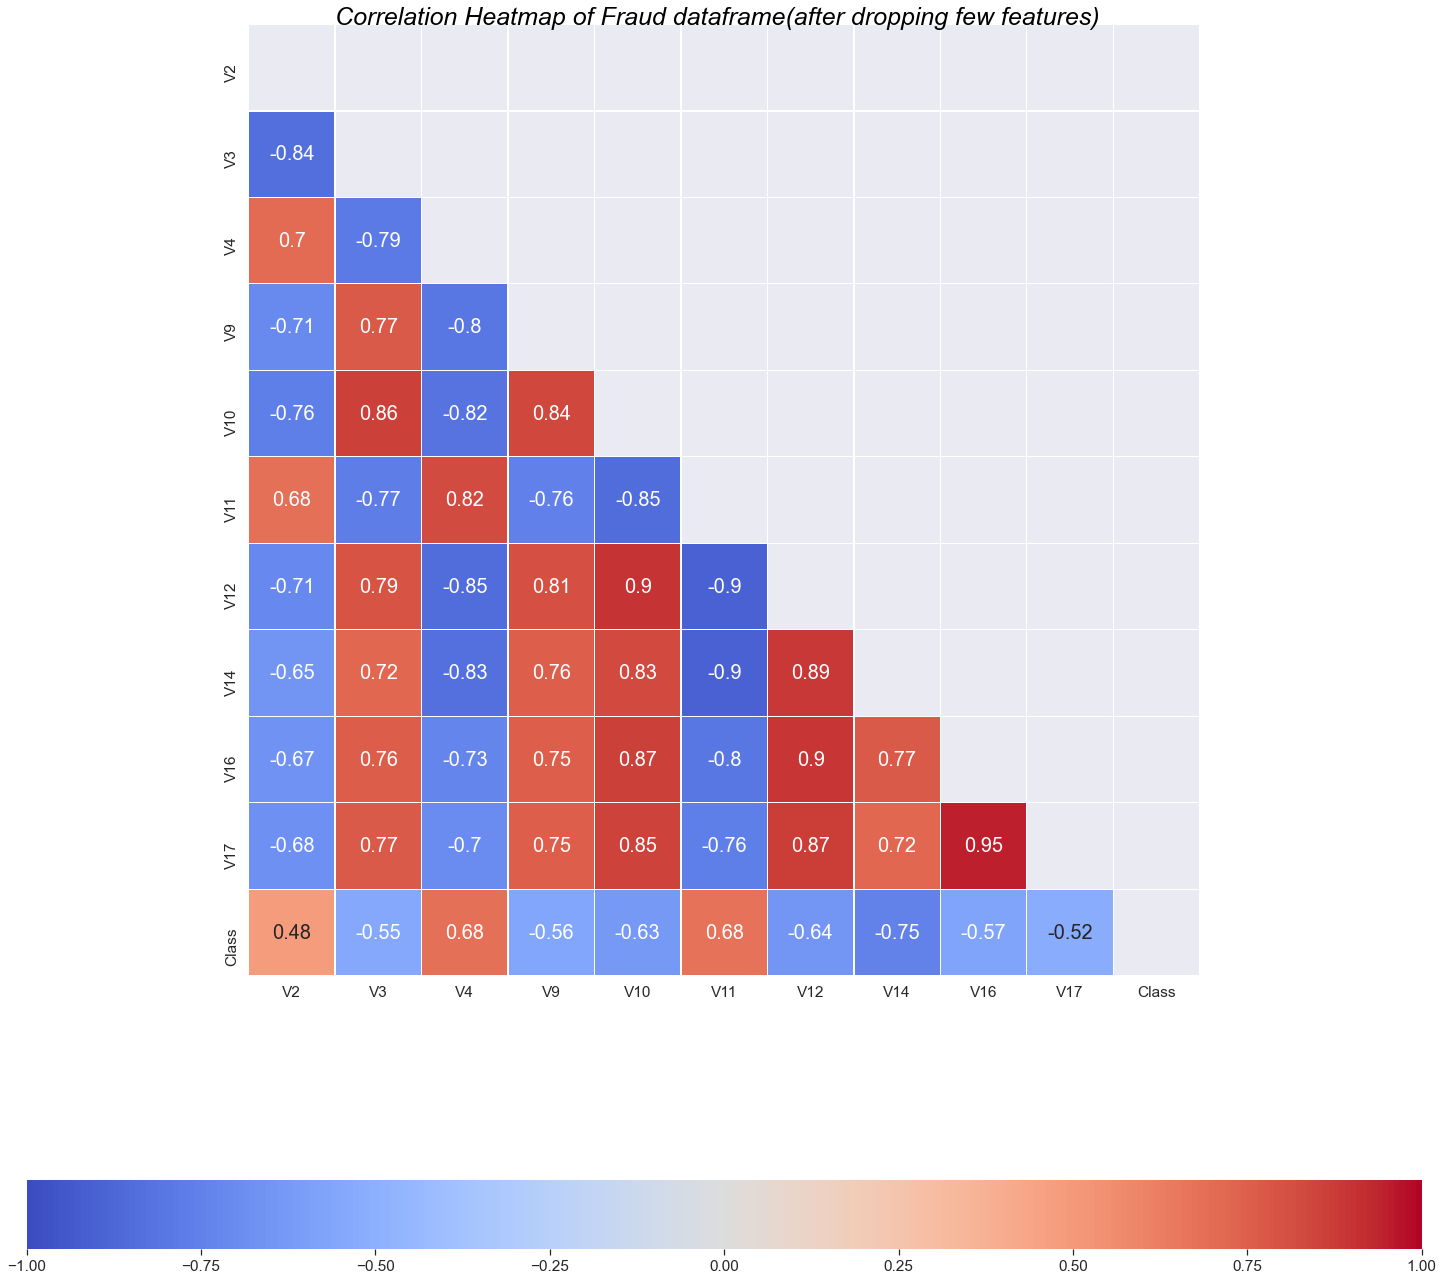

In [128]:
sns.set_theme(style="white")
sns.set(font_scale=1.4)
# Compute the correlation matrix
corr = df_balanced.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1,vmin=-1, center=0, annot=True, annot_kws={"size": 20}, fmt='.2g',square=True, linewidths=.3,cbar_kws= {'orientation': 'horizontal'})
plt.text(1,0, "Correlation Heatmap of Fraud dataframe(after dropping few features)", fontsize = 25, color='Black', fontstyle='italic')
print("--- %s minutes ---" % round((time.time() - start_time)/60,0))

### 2nd stage of feature elimination:

Here, I'm going to drop more features if the correlation between them is very high(let same absolute value of above 0.95):

In [129]:
similar_corr_list = []          # List of more features we don't want to keep
to_remove_list = similar_corr_list + to_remove_list
remaining_features_list = [x for x in remaining_features_list if x not in to_remove_list]
remaining_features_list

['V2', 'V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

In [130]:
df_balanced.drop(columns=similar_corr_list, inplace=True) # Drop the unwanted features from the dataframe

In [131]:
df_balanced.describe()   # Check the change to the remaining features after balancing the dataframe

V2            V3            V4            V9           V10  \
count  54568.000000  54568.000000  54568.000000  54568.000000  54568.000000   
mean       1.590467     -3.155876      2.093751     -1.149969     -2.527855   
std        3.311265      5.784146      3.068168      2.070451      4.026553   
min      -35.097685    -30.558697     -4.897347    -13.320155    -24.588262   
25%       -0.161523     -4.684344     -0.085824     -1.911642     -4.322674   
50%        0.922973     -1.253601      1.342467     -0.702327     -0.796620   
75%        2.414190      0.350961      3.621663      0.117814      0.048935   
max       22.057729      3.945276     12.114672      9.112555     13.811758   

                V11           V12           V14           V16           V17  
count  54568.000000  54568.000000  54568.000000  54568.000000  54568.000000  
mean       1.794681     -2.807639     -3.359080     -1.759685     -2.728277  
std        2.662863      4.358870      4.528325      3.122900      5.265514  
min       -4.224788    -18.683715    -19.214325    -14.129855    -22.667905  
25%       -0.154907     -4.614848     -6.405951     -2.995876     -4.446391  
50%        1.119684     -0.739634     -0.865895     -0.520418     -0.485243  
75%        3.269412      0.195485      0.150393      0.343972      0.250529  
max       12.018913      4.472921      7.754599      8.289890      7.573523

### Plot and elimnating unwanted outlier rows:

Let see the spread of our remaining features by representing them through boxplots and decide which outliers we like to get rid of:

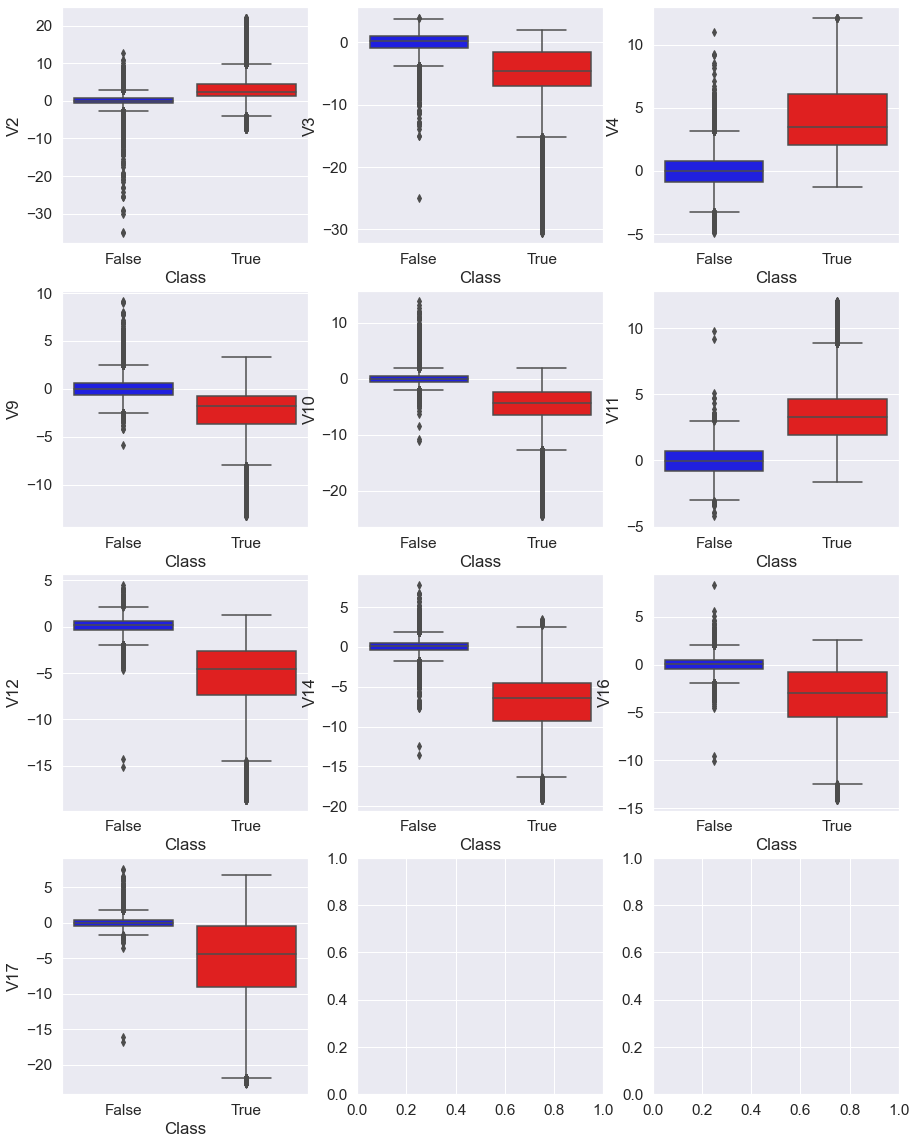

In [132]:
ncols = 3                  # Visualising boxplots to see the behaviour and outliers of each remaining feature
nrows = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,20))
for feature_idx, feature_name in enumerate(remaining_features_list):
    sns.boxplot(x="Class", y=feature_name, data=df_balanced, ax = axes[feature_idx//ncols,feature_idx%ncols], palette = {False : "blue", True:"red"})

Each time we run these codes we have to change the outliers we like to drop, as each time we are going to have different data:

In [133]:
# Dropping the outliers
df_balanced = df_balanced[df_balanced['V2']!=df_balanced['V2'].min()]         
df_balanced = df_balanced[df_balanced['V2']!=df_balanced['V2'].min()]
df_balanced = df_balanced[df_balanced['V2']!=df_balanced['V2'].min()]
df_balanced = df_balanced[df_balanced['V16']!=df_balanced['V16'].max()]
#df_balanced = df_balanced[df_balanced['V3']!=df_balanced['V3'].min()]
#df_balanced = df_balanced[df_balanced['V4']!=df_balanced['V4'].max()]
#df_balanced = df_balanced[df_balanced['V4']!=df_balanced['V4'].max()]
#df_balanced = df_balanced[df_balanced['V4']!=df_balanced['V4'].max()]
#df_balanced = df_balanced[df_balanced['V9']!=df_balanced['V9'].max()]
#df_balanced = df_balanced[df_balanced['V10']!=df_balanced['V10'].max()]
#df_balanced = df_balanced[df_balanced['V14']!=df_balanced['V14'].min()]

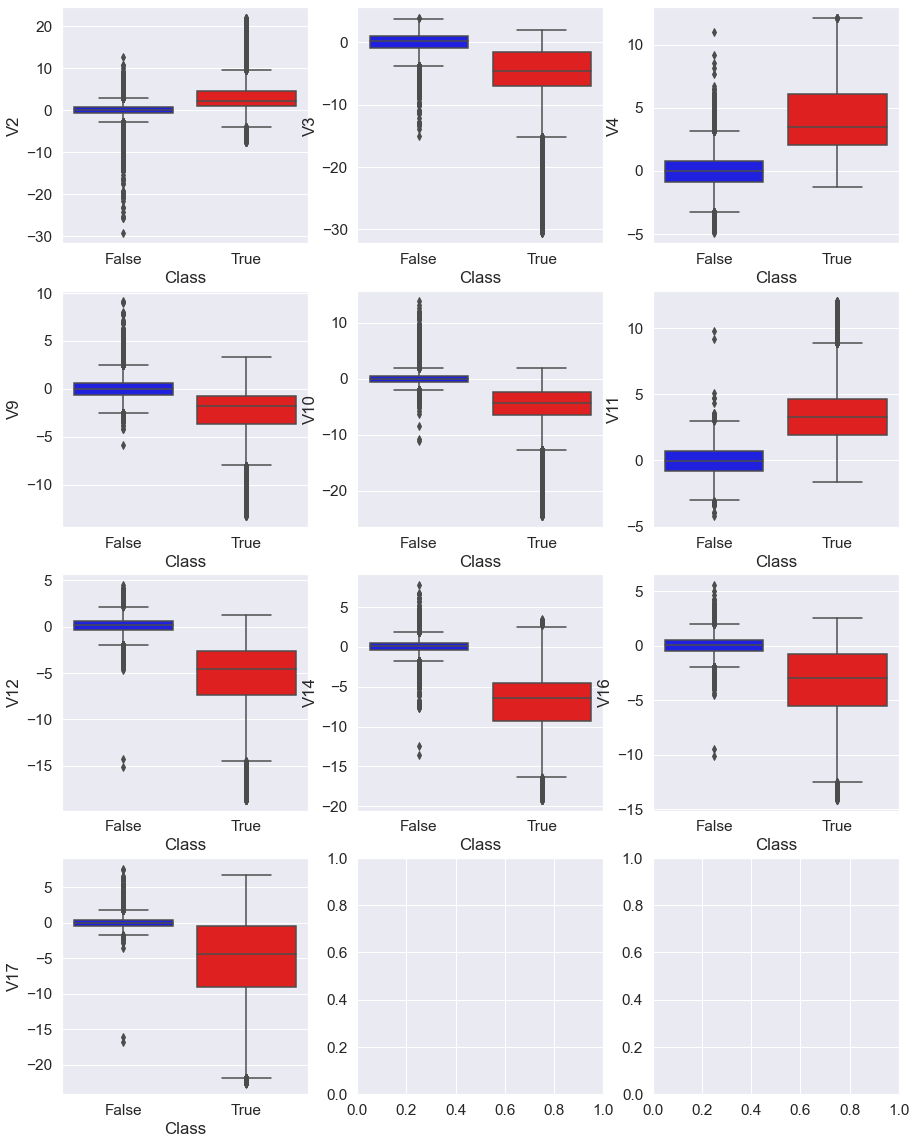

In [134]:
ncols = 3             # Visualising boxplots to see the behaviour of the features after dropping few outliers
nrows = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,20))
for feature_idx, feature_name in enumerate(remaining_features_list):
    sns.boxplot(x="Class", y=feature_name, data=df_balanced, ax = axes[feature_idx//ncols,feature_idx%ncols], palette = {False : "blue", True:"red"})

Now we have the training datasets exactly how we like them to be:

In [135]:
# reassigning X_train and Y_train after getting rid of some of the outliers
Y_train = df_balanced["Class"]
X_train = df_balanced.drop("Class", axis=1)

Modifying the validation sets the same was as the training in terms of getting rid of the unwanted features:

In [136]:
X_val.drop(columns=to_remove_list, inplace=True) # Drop the unwanted features from the dataframe

## Random Forest Classifier:

Now that we are happy with all our training and validation sets, let apply our first Classifier model(on training sets) and tune it based on max_features and max_depth the next stage(Stacking Classifier) and choose the best one according to AUC_ROC score(on validation sets):

In [137]:
best_AUC_ROC = 0    # Best AUC_ROC score in all RandomForest models
for max_depth in tqdm(range(5,10,1)):
    for max_features in range(2,3,1):
        my_classifier = RandomForestClassifier(n_estimators=100, max_features=max_features, max_depth=max_depth)
        my_classifier.fit(X_train, Y_train)                  # Fitting the Classifier
        Y_pred = my_classifier.predict(X_val)                # Predicting fraudness based on the fitted Classifier
        this_AUC_ROC = roc_auc_score(Y_val, Y_pred)          # Current AUC_ROC score
        print("\nAUC-ROC Score:", round(this_AUC_ROC*100,3))

        if this_AUC_ROC > best_AUC_ROC:                     # Establishing if this is the best AUC_ROC score so far
            best_AUC_ROC = this_AUC_ROC
            my_best_rf_classifier = my_classifier
            my_best_max_depth = max_depth
            my_best_max_features = max_features
print("--- %s minutes ---" % round((time.time() - start_time)/60,0))
print(" Best Hyperparameters based on AUC_ROC") # Presenting the best AUC_ROC score and the relavent hyperparameters
print("=======================================")
print("Best AUC_ROC Score:", round(best_AUC_ROC*100,3))
print("Best Max_depth:", my_best_max_depth)
print("Best Max_features:", my_best_max_features)
Y_pred = my_best_rf_classifier.predict(X_val)

C:\Users\AICORE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




AUC-ROC Score: 94.521

AUC-ROC Score: 94.612

AUC-ROC Score: 94.356

AUC-ROC Score: 94.023

AUC-ROC Score: 94.042

--- 3.0 minutes ---
 Best Hyperparameters based on AUC_ROC
Best AUC_ROC Score: 94.612
Best Max_depth: 6
Best Max_features: 2


Best ROC-AUC Score: 94.6
Best Recall Score: 89.6
Best Precision Score: 32.0


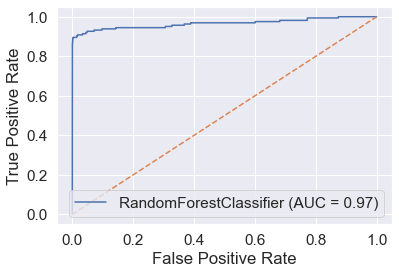

In [138]:
# Presenting the best scores from RandomForest models

print("Best ROC-AUC Score:", round(best_AUC_ROC*100,1))
print("Best Recall Score:", round(recall_score(Y_val, Y_pred)*100,1))
print("Best Precision Score:", round(precision_score(Y_val, Y_pred)*100,1))
plot_roc_curve(my_best_rf_classifier, X_val, Y_val)
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), linestyle='dashed')
plt.show()

## Support Vector Classifier(SVC):

Here we are applying our next model to our training sets, tune it by changing the C and Gamma values and choosing our hyperparameters(for stacking classifier) based on finding the best AUC_ROC score(on validation sets):

In [139]:
best_AUC_ROC = 0                 # Best AUC_ROC score in all RandomForest models
gammas = [0.01,0.05]             # Set of Gammas that we like to try as hyperparameters
cs = [0.01, 0.05]                # Set of Cs that we like to try as hyperparameters
for gamma in tqdm(gammas):
    for c in cs:
        my_classifier = SVC(kernel='rbf', C=c, gamma= gamma ,random_state=42)
        my_classifier.fit(X_train, Y_train)                 # Fitting the Classifier
        Y_pred = my_classifier.predict(X_val)               # Predicting fraudness based on the fitted Classifier 
        this_AUC_ROC = roc_auc_score(Y_val, Y_pred)         # Current AUC_ROC score
        print("ROC-AUC Score:", round(this_AUC_ROC*100,1))
        if this_AUC_ROC > best_AUC_ROC:                   # Establishing if this is the best AUC_ROC score so far
            best_AUC_ROC = this_AUC_ROC
            my_best_svc_classifier=my_classifier
            my_best_C = c
            my_best_Gamma = gamma
print("--- %s minutes ---" % round((time.time() - start_time)/60,0))
# Presenting the best AUC_ROC score and the relavent hyperparameters
print("Best ROC-AUC Score:", round(best_AUC_ROC*100,1)) 
print("Best C:", my_best_C)
print("Best Gamma:", my_best_Gamma)
Y_pred = my_best_svc_classifier.predict(X_val)

C:\Users\AICORE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



ROC-AUC Score: 94.944
ROC-AUC Score: 94.96
ROC-AUC Score: 94.718
ROC-AUC Score: 94.869

--- 7.0 minutes ---
Best ROC-AUC Score: 94.96
Best C: 0.05
Best Gamma: 0.01


Best ROC-AUC Score: 95.0
Best Recall Score: 90.8
Best Precision Score: 15.9


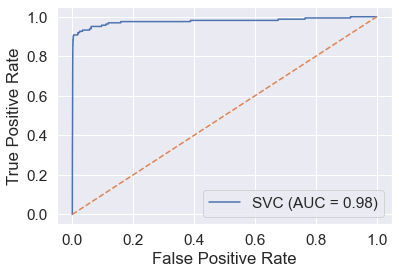

In [140]:
# Presenting the best scores from SVC models

print("Best ROC-AUC Score:", round(best_AUC_ROC*100,1))
print("Best Recall Score:", round(recall_score(Y_val, Y_pred)*100,1))
print("Best Precision Score:", round(precision_score(Y_val, Y_pred)*100,1))
plot_roc_curve(my_best_svc_classifier, X_val, Y_val)
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), linestyle='dashed')
plt.show()

## Stacking Classifier and confusion matrix:

Now that we have the best hyperparameters from our previous implemented models, let combine them together using Stacking Classifier(and apply to the training sets) to get even a better result on AUC_ROC score(on validation sets):

In [141]:
######### Assigning the best performed HyperParameters for StackingClassifier  ##########
clf1 = RandomForestClassifier(n_estimators=100, max_features = my_best_max_features, max_depth = my_best_max_depth)
clf2 = SVC(kernel='rbf', C=my_best_C, gamma=my_best_Gamma, random_state=42)

stackingclassifier = StackingClassifier(estimators=[('rfor', clf1),('SVC', clf2)])
stackingclassifier = stackingclassifier.fit(X_train, Y_train)        ### Fitting the StackingClassifier model #####  
Y_pred = stackingclassifier.predict(X_val) ##### Predicting the Labels based on the validation features 
my_best_classifier=stackingclassifier
print("--- %s minutes ---" % round((time.time() - start_time)/60,0))


--- 11.0 minutes ---


In [142]:
# Presenting the best scores from the StackingClassifier

val_scores = [round(roc_auc_score(Y_val, Y_pred)*100,1),
              round(recall_score(Y_val, Y_pred)*100,1),round(precision_score(Y_val, Y_pred)*100,1)]
print("ROC-AUC score:", round(roc_auc_score(Y_val, Y_pred)*100,1),"%")
print("Recall:", round(recall_score(Y_val, Y_pred)*100,1),"%")
print("Precision:", round(precision_score(Y_val, Y_pred)*100,1), "%")


ROC-AUC score: 94.1 %
Recall: 90.2 %
Precision: 8.0 %


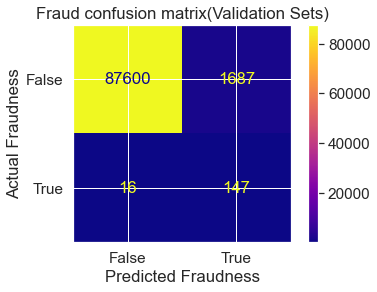

In [143]:
# Presenting the Confusion matrix based on validation sets

title = "Fraud confusion matrix(Validation Sets)"
disp=plot_confusion_matrix(my_best_classifier, X_val, Y_val,cmap=plt.cm.plasma)
disp.ax_.set_title(title)
plt.xlabel('Predicted Fraudness')
plt.ylabel('Actual Fraudness')
plt.show()  

## TEST

Here after importing our Test data and initial process(checking for null and converting the label to boolean type) we apply the same model found from the Stacking Classifier to see the result this time on the test data:

In [144]:
df_test = pd.read_csv('./DATA/creditcard_test.csv') # Importing the test.csv into a dataframe
df_test.isnull().sum().sum()     # Checking if there is any NANs in the test set

0

In [145]:
df_test.Class.unique()   # Checking if the Class column is binary

array([0, 1], dtype=int64)

In [146]:
df_test.Class=df_test.Class.astype("bool")  # Conevering the Class column to a Boolean type
collections.Counter(df_test.Class)        

Counter({False: 85315, True: 128})

In [147]:
# Assigning the test dataframe to X_test and Y_test for later testing and droping unwanted features from the X_test

Y_test = df_test["Class"]                            
X_test = df_test.drop("Class", axis=1)
X_test.drop(columns=to_remove_list, inplace=True)

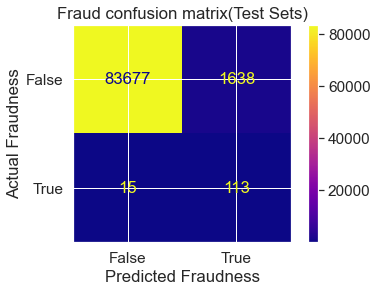

In [148]:
# Presenting the Confusion matrix based on test sets

title = "Fraud confusion matrix(Test Sets)"
disp=plot_confusion_matrix(my_best_classifier, X_test, Y_test,cmap=plt.cm.plasma)
disp.ax_.set_title(title)
plt.xlabel('Predicted Fraudness')
plt.ylabel('Actual Fraudness')
plt.show()  

In [149]:
# Presenting the best scores from the StackingClassifier on the test sets

Y_pred = my_best_classifier.predict(X_test)
test_scores = [round(roc_auc_score(Y_test, Y_pred)*100,1),
              round(recall_score(Y_test, Y_pred)*100,1),round(precision_score(Y_test, Y_pred)*100,1)]
print("ROC_AUC Score:", round(roc_auc_score(Y_test, Y_pred)*100,1),"%")
print("Recall:", round(recall_score(Y_test, Y_pred)*100,1),"%")
print("Precision:", round(precision_score(Y_test, Y_pred)*100,1), "%")

ROC_AUC Score: 93.2 %
Recall: 88.3 %
Precision: 6.5 %


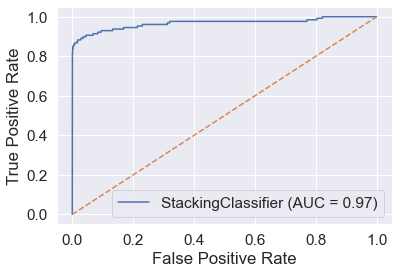

In [150]:
# Plot ROC curve and dashed linear curve
plot_roc_curve(my_best_classifier, X_test, Y_test)
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), linestyle='dashed')
plt.show()

## Final Result

Here we can conclude, based on the methods chosen, we can see a slight lower score than those on validation sets, as exepected.

Please see the summary on the plot below to compare the results based on three different scores: AUC_ROC, Recall and Precision:

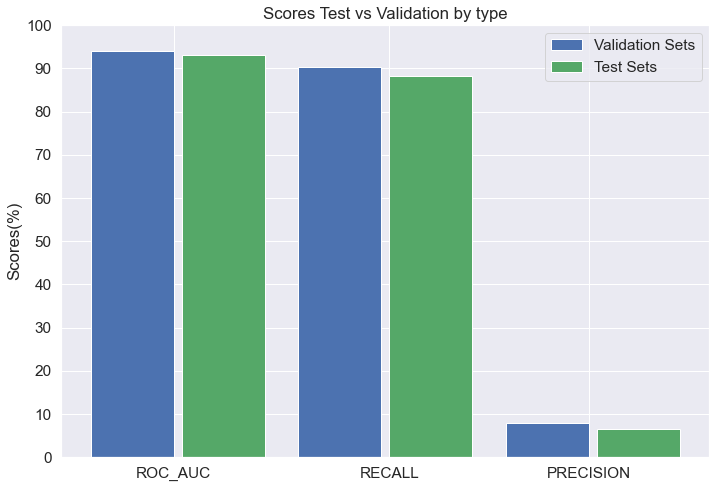

In [176]:
data = [val_scores, test_scores]
X = np.arange(3)
X = X*2.5
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(X + 0.0, data[0], color = 'b', width = 1)
ax.bar(X + 1.1, data[1], color = 'g', width = 1)
plt.setp(ax, xticks=[0.5, 3.1, 5.5], xticklabels=['ROC_AUC', 'RECALL', 'PRECISION'])
ax.set_yticks(np.arange(0, 101, 10))
ax.set_ylabel('Scores(%)')
ax.set_title('Scores Test vs Validation by type')
ax.legend(labels=['Validation Sets', 'Test Sets'])

In [152]:
print("--- %s minutes ---" % round((time.time() - start_time)/60,0))

--- 12.0 minutes ---
